# Multilabel classification problem solution for Reuters-21578

### AIM OF THE PROJECT
The objetive of this project is to test different appraches to NLP problem of multilabel classification and find optimal model that would properly predict document "subject" labels based on a raw document text. <br>
<br><br>
The multilabel classification is a classification for which:
* Number of targets >1
* Number of targets for each sample is a-priori unknown and can differ for different samples
* Target cardinality is equal to 2 (0 or 1) == the sample belongs to a certain target (category) or not

### DATASET USED
Reuters-21578

The full set is available here:
https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection

For the project needs, the author used dataset available in NLTK library which is already split to train and test. It can be loaded to the memory by a command:
*from nltk.corpus import reuters*

The dataset contains:
* almost 8000 train articles
* over 3000 test articles
* there is 90 unique labels
* In average only 1.23 labels are assigned to each train set article

### SUMMARY OF THE PROJECT

#### DATA CLEANING

Before applying a model - the data was cleaned, tokenized and normlized.

#### DATA PRE-PROCESSING

In order to find a best approach to this problem, three different approaches were taken for the words embedding:
* Tf-Idf
* Doc2Vec (model trained on the train corpus)
* FastText (pre-trained model, weights applied in embedding layer of CNN)

#### MODELLING

1. The target labels were binarized with MultiLabelBinarizer
2. A few different models were fitted using pipeline and GridSearchCV (for different pre-processing methods):
    * Inherently supporting multilabels:
        * k-nearest neighbors
        * Random Forest
    * OneVsRest with Linear SVC and Logistic Regression
    * Label Powerset with Linear SVC
    * Convolutional Neural Network

#### METRICS
As in multilabel  - the sample belongs to few labels out of all set of labels, the absolute accuracy is not a good measure (as it will tag as correct only these samples which have all set of labels correclty predicted, without taking into account partial correctness (e.g. we predict correctly 3 out of 4 labels)).
It is proposed to use hamming loss function which would take into account partial correctness.

Each individual category predictions can be evaluated based on traditional metrics like F1 score, Precision and Recall, however, to evaluate full multilabel model, these metrics for each category shall be averaged. There are 2 approaches to do that: micro and macro.

Finally for this project, it was decided to evaluate the model based on a hamming loss and micro & macro f1-score.

Find explanation of micro and macro averaging here:
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [1]:
import numpy as np
import pandas as pd
import re
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

import nltk # text cleaning and datasets 
import re # patterns searching in strings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, multilabel_confusion_matrix, hamming_loss

#### Import data from nltk.corpus and establish train/test inputs and targets

In [2]:
from nltk.corpus import reuters

In [3]:
all_docs = reuters.fileids()
train_doc_names = [doc for doc in all_docs if doc.startswith("train")]
test_doc_names = [doc for doc in all_docs if doc.startswith("test")]

In [4]:
X_train_raw, y_train_raw = zip(*[(reuters.raw(doc), reuters.categories(doc)) for doc in train_doc_names])
X_test_raw, y_test_raw= zip(*[(reuters.raw(doc), reuters.categories(doc)) for doc in test_doc_names])

## Review the data:

In [5]:
# Number of articles:
print(f"Number of train articles: {len(X_train_raw)}")
print(f"Number of test articles: {len(X_test_raw)}")

Number of train articles: 7769
Number of test articles: 3019


#### Review labels

In [6]:
y_train_raw_flat = pd.Series(itertools.chain(*y_train_raw))
y_test_raw_flat = pd.Series(itertools.chain(*y_train_raw))

In [7]:
print(f"Avg number of labels per article in train set: {(len(y_train_raw_flat) / len(y_train_raw) ):.2f}")
# print(f"Avg number of labels per article in test set: {(len(y_test_raw_flat) / len(y_test_raw) ):.2f}")

Avg number of labels per article in train set: 1.23


In [8]:
# Count number of labels for each article
labels_len = [len(labels) for labels in y_train_raw]
# Group 
labels_freq = {n: labels_len.count(n) for n in labels_len}
labels_freq = dict(sorted(labels_freq.items()))
print(f"Number of labels assigned to article: Total number of such occurances")
labels_freq

Number of labels assigned to article: Total number of such occurances


{1: 6577,
 2: 865,
 3: 192,
 4: 59,
 5: 37,
 6: 22,
 7: 5,
 8: 5,
 9: 3,
 10: 2,
 11: 1,
 15: 1}

Conclusion: For most of the cases in the train set - there is only 1 label associated with article.

#### Review classes

In [9]:
print(f"Total number of classes: {len(reuters.categories())}")

Total number of classes: 90


In [10]:
cat_distr = y_train_raw_flat.value_counts()
cat_distr.head(5)

earn        2877
acq         1650
money-fx     538
grain        433
crude        389
dtype: int64

In [11]:
cat_distr.tail(5)

lin-oil       1
cotton-oil    1
nkr           1
rye           1
sun-meal      1
dtype: int64

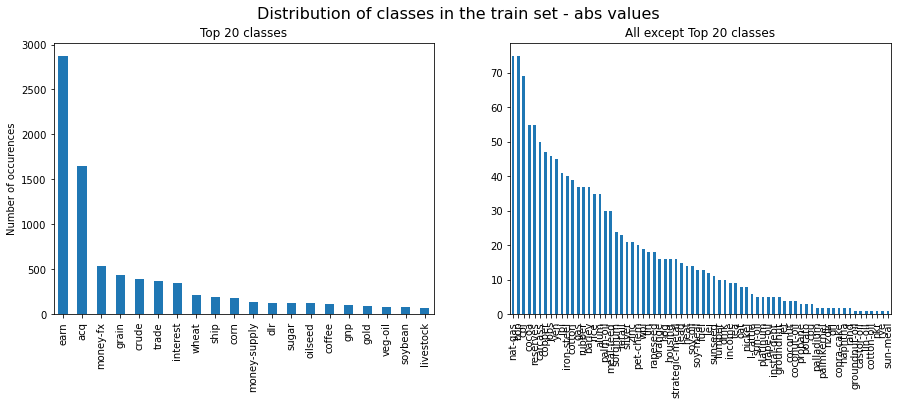

In [12]:
n=20 # split between left and right graph (number of top classes)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of classes in the train set - abs values', fontsize = 16)

plt.subplot(1,2,1)
cat_distr[:n].plot.bar()
plt.ylabel(f'Number of occurences');
plt.title(f'Top {n} classes');

plt.subplot(1,2,2)
cat_distr[n:].plot.bar()
plt.title(f'All except Top {n} classes');

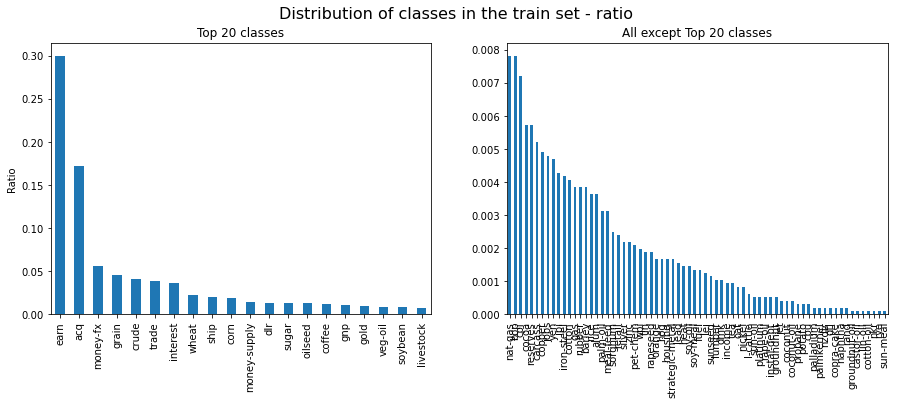

In [13]:
n=20 # split between left and right graph (number of top classes)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of classes in the train set - ratio', fontsize = 16)

plt.subplot(1,2,1)
(cat_distr[:n]/cat_distr.sum()).plot.bar()
plt.ylabel(f'Ratio');
plt.title(f'Top {n} classes');

plt.subplot(1,2,2)
(cat_distr[n:]/cat_distr.sum()).plot.bar()
plt.title(f'All except Top {n} classes');

Conclusion: Top 2 classes are far more frequent than other classes (more than 45% of all targets)

#### Review the raw articles

In [14]:
type(X_train_raw[0])

str

In [15]:
art_len = [len(art) for art in X_train_raw]

In [16]:
print(f"Character count for the shortest article: {min(art_len)}")
print(f"Character count for the longest article: {max(art_len)}")

Character count for the shortest article: 27
Character count for the longest article: 8898


In [17]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
# ax1.hist(art_len, bins=50, rwidth = 0.9);

(0.0, 200.0)

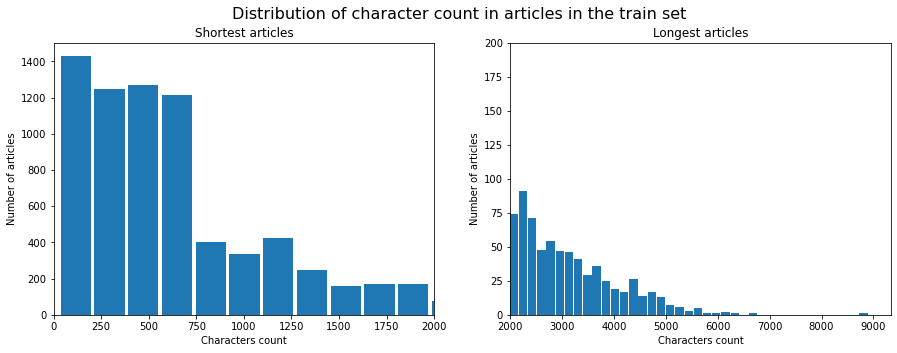

In [18]:
n=2000 # split between left and right graph (number of characters)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of character count in articles in the train set', fontsize = 16)

plt.subplot(1,2,1)
plt.hist(art_len, bins=50, rwidth = 0.9);
plt.ylabel(f'Number of articles');
plt.xlabel(f'Characters count');
plt.title(f'Shortest articles');
plt.xlim(0,n)

plt.subplot(1,2,2)
plt.hist(art_len, bins=50, rwidth = 0.9);
plt.ylabel(f'Number of articles');
plt.xlabel(f'Characters count');
plt.title(f'Longest articles');
plt.xlim(n,)
plt.ylim(0,200)

# plt.tight_layout()
# ax.set(ylabel = 'aaa')

In [19]:
X_train_raw[0][:300]

'BAHIA COCOA REVIEW\n  Showers continued throughout the week in\n  the Bahia cocoa zone, alleviating the drought since early\n  January and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  Comissaria Smith said in its weekly review.\n      The dry p'

<br><br><br>
## Clean text

#### Functions definition

In [20]:
def remove_html(text_list):
    text_clean = [re.sub("<.+?>", " ", el) for el in text]
    return text_clean

In [21]:
def convert_to_lower(text):
    text_clean = [el.lower() for el in text]
    return text_clean

In [22]:
def remove_control_chars(text): # (e.g. \n \t...)
    text_clean = [re.sub("\s+", " ", el) for el in text]
    return text_clean

In [23]:
def tokenization(text):
    text_clean = [nltk.word_tokenize(el) for el in text]
    return text_clean

In [24]:
def remove_stopwords(text):
    stopwords =nltk.corpus.stopwords.words("english")
    text_clean = [[w for w in el if w not in stopwords] for el in text]
    return text_clean

In [25]:
def remove_punctuations(text):
    import string
    punctuations = [char for char in string.punctuation]
    
    text_clean = [[w for w in el if w not in punctuations] for el in text]
    return text_clean

In [26]:
def token_normalization(text):
    # Token normalization - stemming with PorterStemmer 
    # It is not important to keep "real" language words, so stemming (as being faster) is a better choice than lemmatization
    stemmer = nltk.PorterStemmer()
    
    text_clean = [[stemmer.stem(w) for w in el] for el in text]
    return text_clean

In [27]:
def remove_numbers(text):
    
    text_clean = [[re.sub('[^A-Za-z]+', '', w) for w in el] for el in text]
    # Remove empty strings after number removal
    text_clean = [list(filter(None, el)) for el in text_clean]
    
    return text_clean

In [28]:
def remove_short_words(text, k):
    text_clean = [[w for w in el if len(w) > k] for el in text]
    return text_clean

In [29]:
def merge_back(text):
    text_merge = [" ".join(el) for el in text]
    return text_merge

In [30]:
# Combine all functions above
def text_preprocess(text):
#     text = remove_html(text)
    text = convert_to_lower(text)
    text = remove_control_chars(text)
    tokens = tokenization(text)
    tokens = remove_stopwords(tokens)
    tokens = remove_punctuations(tokens)
    tokens = token_normalization(tokens)
    tokens = remove_numbers(tokens)
    text = remove_short_words(tokens, 2)
    text_final = merge_back(text)
    
    return tokens, text_final

#### Let's apply cleaning functions on train set:

In [31]:
# Convert to lower case
X_train =  convert_to_lower(X_train_raw)
X_train[0][:300]

'bahia cocoa review\n  showers continued throughout the week in\n  the bahia cocoa zone, alleviating the drought since early\n  january and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  comissaria smith said in its weekly review.\n      the dry p'

In [32]:
# Remove control characters
X_train =  remove_control_chars(X_train)
X_train[0][:300]

'bahia cocoa review showers continued throughout the week in the bahia cocoa zone, alleviating the drought since early january and improving prospects for the coming temporao, although normal humidity levels have not been restored, comissaria smith said in its weekly review. the dry period means the '

In [33]:
# Tokenization
tokens_train = tokenization(X_train)
print(tokens_train[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'the', 'week', 'in', 'the', 'bahia', 'cocoa', 'zone', ',', 'alleviating', 'the', 'drought', 'since', 'early', 'january']


In [34]:
# Remove stopwords
tokens_train = remove_stopwords(tokens_train)
print(tokens_train[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'week', 'bahia', 'cocoa', 'zone', ',', 'alleviating', 'drought', 'since', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao']


In [35]:
# Remove punctuations
tokens_train = remove_punctuations(tokens_train)
print(tokens_train[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'alleviating', 'drought', 'since', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao', 'although']


In [36]:
# Token normalization
tokens_train = token_normalization(tokens_train)
print(tokens_train[0][:50])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', '22', '155,221', 'bag', '60', 'kilo', 'make', 'cumul', 'total', 'season', '5.93', 'mln']


In [37]:
# Remove numbers 
# Consider converting all numbers to "number" string instead of removing them ???
tokens_train = remove_numbers(tokens_train) 
print(tokens_train[0][:50])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', 'bag', 'kilo', 'make', 'cumul', 'total', 'season', 'mln', 'stage', 'last', 'year', 'seem']


In [38]:
# Remove words shorter than 2
tokens_train = remove_short_words(tokens_train, 2)
print(tokens_train[0][:60])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', 'bag', 'kilo', 'make', 'cumul', 'total', 'season', 'mln', 'stage', 'last', 'year', 'seem', 'cocoa', 'deliv', 'earlier', 'consign', 'includ', 'arriv', 'figur', 'comissaria', 'smith', 'said']


In [39]:
X_train = merge_back(tokens_train)
X_train[0][:500]

'bahia cocoa review shower continu throughout week bahia cocoa zone allevi drought sinc earli januari improv prospect come temporao although normal humid level restor comissaria smith said weekli review dri period mean temporao late year arriv week end februari bag kilo make cumul total season mln stage last year seem cocoa deliv earlier consign includ arriv figur comissaria smith said still doubt much old crop cocoa still avail harvest practic come end total bahia crop estim around mln bag sale '

#### Let's review frequency and size of cleaned data:

In [40]:
indexes = [word for doc in tokens_train for word in doc]  

In [41]:
from collections import Counter

In [42]:
# Most frequent words:
corpus_freq = Counter(indexes).most_common()
corpus_freq[:10]

[('said', 18844),
 ('mln', 13102),
 ('dlr', 9750),
 ('pct', 7406),
 ('year', 6010),
 ('net', 4566),
 ('loss', 4312),
 ('share', 4184),
 ('billion', 4110),
 ('compani', 4037)]

In [43]:
uniques = [word for word,freq in Counter(indexes).items() if freq == 1]

In [44]:
print(f"There are {len(indexes)} words in the train corpus,")
print(f"- consisting of {len(Counter(indexes))} unique words,")
print(f"- out of which {len(uniques)} words appear only once the train corpus!")

There are 596080 words in the train corpus,
- consisting of 19850 unique words,
- out of which 7983 words appear only once the train corpus!


#### Let's do the same cleaning transofrmations with test set (using combined function)

In [45]:
tokens_test, X_test = text_preprocess(X_test_raw)

In [46]:
tokens_test[0][:10]

['asian',
 'export',
 'fear',
 'damag',
 'usjapan',
 'rift',
 'mount',
 'trade',
 'friction',
 'us']

<br><br><br>
## Text vectorization
This section will present the documents vectorization by TfIdf and Doc2Vec approaches.

### TFIDF
This method is shown here only for text exploration and presentation purposes. The results of vectorization in this section is not used in the models, as in the models, the TfIdf is incorporated in the pipeline.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
min_df = 3
max_df = 0.8

In [49]:
tfidf_vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)

tfidf = tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)

X_test_tfidf = tfidf.transform(X_test)

In [50]:
print(f"The number of remaining tokens is {X_train_tfidf.shape[1]} out of {len(Counter(indexes))} unique words in original cleaned corpus")

The number of remaining tokens is 7188 out of 19850 unique words in original cleaned corpus


In [51]:
# Take a dense tfidf with feature names
df_tfidf = pd.DataFrame(X_train_tfidf.todense().T, index=tfidf.get_feature_names())

#### TfIdf is a sparse matrix even after applying min and max number of words...

In [52]:
df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,7759,7760,7761,7762,7763,7764,7765,7766,7767,7768
aaa,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aac,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aar,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abandon,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abat,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zoet,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zone,0.044526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zorinski,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zuccherifici,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's see TfIdf values > 0 for the first document: 

In [53]:
doc = 0
df_tfidf.loc[df_tfidf[doc] > 0, [doc]]

,0
allevi,0.056771
almost,0.038594
also,0.020205
although,0.033906
aprilmay,0.055303
...,...
went,0.043398
would,0.019074
year,0.029054
york,0.258704


#### Let's see the values of TfIdf for 10 random documents: 

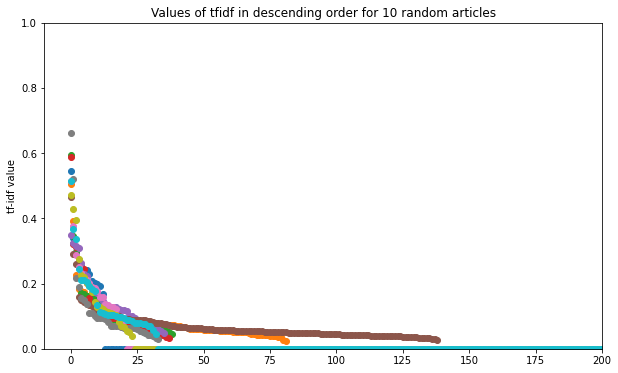

In [54]:
import random
n = 10 # Number of articles to be presented
randomlist = random.sample(range(0, X_train_tfidf.shape[0]), n)

plt.figure(figsize=(10,6))

for i in randomlist:
    rowssort = X_train_tfidf.getrow(i).todense().A1.argsort()[::-1]
    valsort = df_tfidf[i].values[rowssort]
    
    plt.plot(valsort, 'o')

ax = plt.gca()
ax.set(xlim=(-10, 200), ylim=(0, 1),
       ylabel='tf-idf value',
       title=f'Values of tfidf in descending order for {n} random articles');


<br><br><br>
### Doc2Vec
This section will build a Doc2Vec model trained on the corpus available in the dataset. This Doc2Vec will be used and provided to the classifier instead of TfIdf.

In [55]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import multiprocessing

In [56]:
TaggedDocument

gensim.models.doc2vec.TaggedDocument

#### Let's train my own model:

In [57]:
# Create train corpus objects from tokenized train set 
D2V_train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens_train)]

In [58]:
D2V_train_corpus[1]

TaggedDocument(words=['comput', 'termin', 'system', 'cpml', 'complet', 'sale', 'comput', 'termin', 'system', 'inc', 'said', 'complet', 'sale', 'share', 'common', 'stock', 'warrant', 'acquir', 'addit', 'one', 'mln', 'share', 'sedio', 'lugano', 'switzerland', 'dlr', 'compani', 'said', 'warrant', 'exercis', 'five', 'year', 'purchas', 'price', 'dlr', 'per', 'share', 'comput', 'termin', 'said', 'sedio', 'also', 'right', 'buy', 'addit', 'share', 'increas', 'total', 'hold', 'pct', 'comput', 'termin', 'outstand', 'common', 'stock', 'certain', 'circumst', 'involv', 'chang', 'control', 'compani', 'compani', 'said', 'condit', 'occur', 'warrant', 'would', 'exercis', 'price', 'equal', 'pct', 'common', 'stock', 'market', 'price', 'time', 'exceed', 'dlr', 'per', 'share', 'comput', 'termin', 'also', 'said', 'sold', 'technolgi', 'right', 'dot', 'matrix', 'impact', 'technolog', 'includ', 'futur', 'improv', 'woodco', 'inc', 'houston', 'tex', 'dlr', 'said', 'would', 'continu', 'exclus', 'worldwid', 'licen

In [59]:
# Params:
vector_size = 100 # Same as we will use for CNN model
min_count= 3 # Same as for TfIdf

cores = multiprocessing.cpu_count()-1

#### The next 4 cells trains the model and saves it to the drive. Skip them and load model from the drive if you don't want to wait too long

In [60]:
# 1. Create DBOW model (dm=0 --> DBOW, while dm=1 --> PV-DM)
# model_Doc2Vec =  Doc2Vec(dm=0, vector_size = vector_size, min_count = min_count, window = 4, epochs = 40, workers=cores)

In [61]:
# 2. Pass corpus to build vocabulary
# model_Doc2Vec.build_vocab(D2V_train_corpus)

In [62]:
# 3. Train model prepared train corpus
# model_Doc2Vec.train(D2V_train_corpus,
#                     total_examples = model_Doc2Vec.corpus_count,
#                     epochs = model_Doc2Vec.epochs)

In [63]:
# 4. Save the model
# model_Doc2Vec.save('model_Doc2Vec')

In [64]:
model_Doc2Vec = Doc2Vec.load('model_Doc2Vec')

In [65]:
# Build vector feature from train corpus:
X_train_D2V = np.zeros((len(tokens_train), vector_size))
for i in range(len(tokens_train)):
    X_train_D2V[i]=model_Doc2Vec.infer_vector(tokens_train[i])

X_train_D2V[0][:10]

array([-0.94684154, -0.16295987,  0.22185573,  0.42019096,  1.20932579,
       -0.13093458, -0.12016711, -0.81358808,  0.2468235 , -0.47098747])

In [66]:
# Build vector feature from test corpus:
X_test_D2V = np.zeros((len(tokens_test), vector_size))
for i in range(len(tokens_test)):
    X_test_D2V[i]=model_Doc2Vec.infer_vector(tokens_test[i])

<br><br><br>
## Target binarization
In the multilabel problem, the number of associated labels is unknown apriori, thus number of labels will differ depending on the document. We would like to have the same number of labels for each document.

For each document, MultiLabelBinarizer will create a vector with n number of binary values (n being a number of possible labels, here = 90) and assigns 1's to appropriate document tags.

In [67]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train_raw)
y_test = mlb.transform(y_test_raw)

In [68]:
y_train_raw[9]

['cocoa', 'coffee', 'sugar']

In [69]:
y_train[9]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

<br><br><br>
# Models

#### Support function to plot metrics (taken from a web):

In [70]:
def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
#     ModelsPerformance[modelName] = micro_f1

<br><br>
## Models inherently supporting multilabel problems
* Random Forest
* kNN

with 2 different pre-processing approaches: TfIdf & Doc2Vec

### Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

#### Random Forest with TfIdf

In [76]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', RandomForestClassifier(n_estimators = 100, random_state=42))
])

param_grid = {
    'clf__n_estimators': [25, 50, 100],
#     'clf__max_depth': [4, 6, 8, 10],
    'clf__criterion': ['gini', 'entropy']
}

grid_RF_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_RF_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_RF_tfidf.best_params_}")
print(f"Train accuracy: {grid_RF_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_RF_tfidf.score(X_test, y_test)}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.4min finished


Best params: {'clf__criterion': 'gini', 'clf__n_estimators': 100}
Train accuracy: 0.9920195649375724
Test accuracy: 0.663795958926797


In [77]:
y_pred = grid_RF_tfidf.best_estimator_.predict(X_test)
metricsReport('RF tfidf', y_test, y_pred) 

------RF tfidf Model Metrics-----
Accuracy: 0.6638
Hamming Loss: 0.0058
Precision:
  - Macro: 0.3960
  - Micro: 0.9653
Recall:
  - Macro: 0.1095
  - Micro: 0.6026
F1-measure:
  - Macro: 0.1540
  - Micro: 0.7420


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
# multilabel_confusion_matrix(y_test, y_pred )

#### Random Forest with Doc2Vec

In [79]:
pipe = Pipeline(steps=[
    ('clf', RandomForestClassifier(n_estimators = 100, random_state=42))
])

param_grid = {
    'clf__n_estimators': [25, 50, 100],
#     'clf__max_depth': [4, 6, 8, 10],
    'clf__criterion': ['gini', 'entropy']
}

grid_RF_D2V = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_RF_D2V.fit(X_train_D2V, y_train)

print(f"Best params: {grid_RF_D2V.best_params_}")
print(f"Train accuracy: {grid_RF_D2V.score(X_train_D2V, y_train)}")
print(f"Test accuracy: {grid_RF_D2V.score(X_test_D2V, y_test)}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 24.2min finished


Best params: {'clf__criterion': 'entropy', 'clf__n_estimators': 25}
Train accuracy: 0.9864847470716952
Test accuracy: 0.46372971182510764


In [80]:
y_pred = grid_RF_D2V.best_estimator_.predict(X_test_D2V)
metricsReport('RF Doc2Vec', y_test, y_pred) 

------RF Doc2Vec Model Metrics-----
Accuracy: 0.4637
Hamming Loss: 0.0086
Precision:
  - Macro: 0.1900
  - Micro: 0.9676
Recall:
  - Macro: 0.0318
  - Micro: 0.3910
F1-measure:
  - Macro: 0.0456
  - Micro: 0.5570


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### KNN

In [81]:
from sklearn.neighbors import KNeighborsClassifier

#### KNN with TfIdf

In [84]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', KNeighborsClassifier())
])

param_grid = {
    'clf__n_neighbors': [3,5,7,9,11],
    'clf__weights': ['uniform', 'distance']
}

grid_kNN_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_kNN_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_kNN_tfidf.best_params_}")
print(f"Train accuracy: {grid_kNN_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_kNN_tfidf.score(X_test, y_test)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.9min finished


Best params: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
Train accuracy: 0.9918908482430171
Test accuracy: 0.7512421331566744


In [85]:
y_pred = grid_kNN_tfidf.best_estimator_.predict(X_test)
metricsReport('kNN tfidf', y_test, y_pred)

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------kNN tfidf Model Metrics-----
Accuracy: 0.7512
Hamming Loss: 0.0052
Precision:
  - Macro: 0.6271
  - Micro: 0.8551
Recall:
  - Macro: 0.3961
  - Micro: 0.7532
F1-measure:
  - Macro: 0.4537
  - Micro: 0.8009


#### KNN with Doc2Vec

In [86]:
pipe = Pipeline(steps=[
    ('clf', KNeighborsClassifier())
])

param_grid = {
    'clf__n_neighbors': [3,5,7,9,11],
    'clf__weights': ['uniform', 'distance']
}

grid_kNN_D2V = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_kNN_D2V.fit(X_train_D2V, y_train)

print(f"Best params: {grid_kNN_D2V.best_params_}")
print(f"Train accuracy: {grid_kNN_D2V.score(X_train_D2V, y_train)}")
print(f"Test accuracy: {grid_kNN_D2V.score(X_test_D2V, y_test)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.2min finished


Best params: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Train accuracy: 1.0
Test accuracy: 0.5935740311361378


In [87]:
y_pred = grid_kNN_D2V.best_estimator_.predict(X_test_D2V)
metricsReport('kNN D2V', y_test, y_pred)

------kNN D2V Model Metrics-----
Accuracy: 0.5936
Hamming Loss: 0.0092
Precision:
  - Macro: 0.4157
  - Micro: 0.7069
Recall:
  - Macro: 0.1976
  - Micro: 0.5713
F1-measure:
  - Macro: 0.2386
  - Micro: 0.6319


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<br><br>
## Models with OneVsRest approach
* Linear SVC
* Logistic Regression

also with 2 different pre-processing: TfIdf & Doc2Vec

In [88]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB # Veeery bad predictions - highly sensitive to correlation between features
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#### LinearSVC with TfIdf

In [89]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter = 10000)))
])

param_grid = {
     'clf__estimator__C': [0.01, 0.1, 1, 10, 100]
}

grid_LinSVC_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LinSVC_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_LinSVC_tfidf.best_params_}")
print(f"Train accuracy: {grid_LinSVC_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LinSVC_tfidf.score(X_test, y_test)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished


Best params: {'clf__estimator__C': 1}
Train accuracy: 0.9725833440597246
Test accuracy: 0.8138456442530639


In [90]:
y_pred = grid_LinSVC_tfidf.best_estimator_.predict(X_test)
metricsReport('LinSVC tfidf', y_test, y_pred)

------LinSVC tfidf Model Metrics-----
Accuracy: 0.8138
Hamming Loss: 0.0033
Precision:
  - Macro: 0.6384
  - Micro: 0.9462
Recall:
  - Macro: 0.3938
  - Micro: 0.8026
F1-measure:
  - Macro: 0.4647
  - Micro: 0.8685


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### LinearSVC with Doc2Vec

In [91]:
pipe = Pipeline(steps=[
    ('clf', OneVsRestClassifier(LinearSVC(max_iter = 10000)))
])

param_grid = {
     'clf__estimator__C': [0.01, 0.1, 1, 10, 100]
}

grid_LinSVC_D2V = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LinSVC_D2V.fit(X_train_D2V, y_train)

print(f"Best params: {grid_LinSVC_D2V.best_params_}")
print(f"Train accuracy: {grid_LinSVC_D2V.score(X_train_D2V, y_train)}")
print(f"Test accuracy: {grid_LinSVC_D2V.score(X_test_D2V, y_test)}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.8min finished


Best params: {'clf__estimator__C': 0.1}
Train accuracy: 0.8182520272879392
Test accuracy: 0.7098376946008612


In [92]:
y_pred = grid_LinSVC_D2V.best_estimator_.predict(X_test_D2V)
metricsReport('LinSVC D2V', y_test, y_pred)

------LinSVC D2V Model Metrics-----
Accuracy: 0.7098
Hamming Loss: 0.0054
Precision:
  - Macro: 0.4271
  - Micro: 0.8241
Recall:
  - Macro: 0.2802
  - Micro: 0.7706
F1-measure:
  - Macro: 0.3159
  - Micro: 0.7964


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Logistic Regression with TfIdf

In [94]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter = 10000)))
])

param_grid = {
            'clf__estimator__C': [0.01, 0.1, 1, 10, 100],
            'clf__estimator__solver': ['newton-cg', 'lbfgs', 'liblinear']
}

grid_LR_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LR_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_LR_tfidf.best_params_}")
print(f"Train accuracy: {grid_LR_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LR_tfidf.score(X_test, y_test)}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.1min finished


Best params: {'clf__estimator__C': 100, 'clf__estimator__solver': 'newton-cg'}
Train accuracy: 0.9902175312137984
Test accuracy: 0.8022524014574363


In [95]:
y_pred = grid_LR_tfidf.best_estimator_.predict(X_test)
metricsReport('LogReg tfidf', y_test, y_pred)

------LogReg tfidf Model Metrics-----
Accuracy: 0.8023
Hamming Loss: 0.0035
Precision:
  - Macro: 0.6084
  - Micro: 0.9416
Recall:
  - Macro: 0.3663
  - Micro: 0.7917
F1-measure:
  - Macro: 0.4363
  - Micro: 0.8601


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Logistic Regression with Doc2Vec

In [96]:
pipe = Pipeline(steps=[
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter = 10000)))
])

param_grid = {
     'clf__estimator__C': [0.01, 0.1, 1, 10, 100],
     'clf__estimator__solver': ['newton-cg', 'lbfgs', 'liblinear']
}

grid_LR_D2V = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LR_D2V.fit(X_train_D2V, y_train)

print(f"Best params: {grid_LR_D2V.best_params_}")
print(f"Train accuracy: {grid_LR_D2V.score(X_train_D2V, y_train)}")
print(f"Test accuracy: {grid_LR_D2V.score(X_test_D2V, y_test)}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.7min finished


Best params: {'clf__estimator__C': 1, 'clf__estimator__solver': 'liblinear'}
Train accuracy: 0.8165787102587205
Test accuracy: 0.7121563431599868


In [97]:
y_pred = grid_LR_D2V.best_estimator_.predict(X_test_D2V)
metricsReport('LinSVC D2V', y_test, y_pred)

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------LinSVC D2V Model Metrics-----
Accuracy: 0.7122
Hamming Loss: 0.0053
Precision:
  - Macro: 0.4201
  - Micro: 0.8352
Recall:
  - Macro: 0.2642
  - Micro: 0.7634
F1-measure:
  - Macro: 0.3022
  - Micro: 0.7977


<br><br>
## Model - Label Powerset
Some labels can be correleted - this information is lost in OneVsRest models. Let's verify the correlation and apply Label Powerset model with Linear SVC.

### Labels correlation

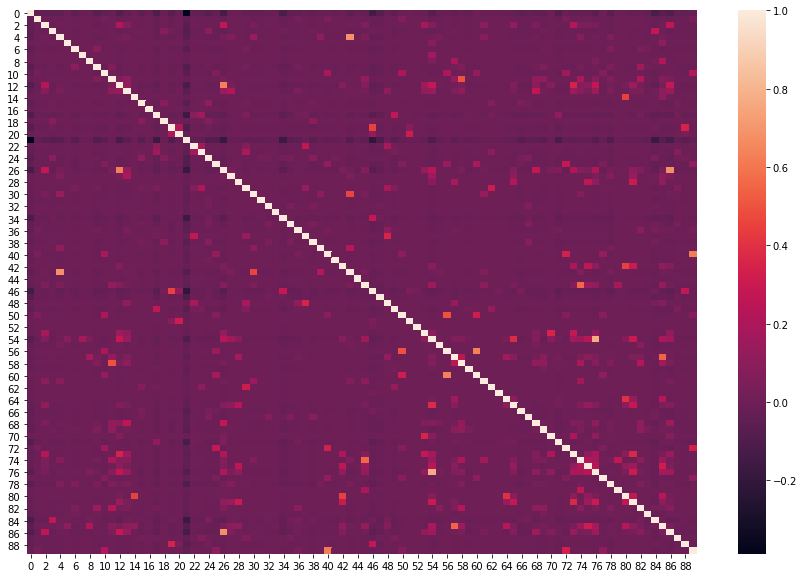

In [98]:
plt.figure(figsize = (15,10))
sns.heatmap(pd.DataFrame(y_train).corr())

The labels do not seem to be stronly correlated, but some patterns might be observed

### Label Powerset LinearSVC

In [99]:
from skmultilearn.problem_transform import LabelPowerset

#### Label Powerset LinearSVC with TfIdf

In [100]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', LabelPowerset(LinearSVC(max_iter = 10000)))
])

param_grid = {
     'clf__classifier__C': [0.01, 0.1, 0.5, 1, 10, 100]
}

grid_LP_LinSVC_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LP_LinSVC_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_LP_LinSVC_tfidf.best_params_}")
print(f"Train accuracy: {grid_LP_LinSVC_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LP_LinSVC_tfidf.score(X_test, y_test)}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


Best params: {'clf__classifier__C': 1}
Train accuracy: 0.9814647959840391
Test accuracy: 0.8436568400132494


In [101]:
y_pred = grid_LP_LinSVC_tfidf.best_estimator_.predict(X_test)
metricsReport('LP LinSVC tfidf', y_test, y_pred)

------LP LinSVC tfidf Model Metrics-----
Accuracy: 0.8437
Hamming Loss: 0.0036
Precision:
  - Macro: 0.6970
  - Micro: 0.9050
Recall:
  - Macro: 0.4920
  - Micro: 0.8269
F1-measure:
  - Macro: 0.5413
  - Micro: 0.8642


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Label Powerset LinearSVC with Doc2Vec

In [102]:
pipe = Pipeline(steps=[
    ('clf', LabelPowerset(LinearSVC(max_iter = 10000)))
])

param_grid = {
     'clf__classifier__C': [0.01, 0.1, 0.5, 1, 10, 100]
}

grid_LP_LinSVC_D2V = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LP_LinSVC_D2V.fit(X_train_D2V, y_train)

print(f"Best params: {grid_LP_LinSVC_D2V.best_params_}")
print(f"Train accuracy: {grid_LP_LinSVC_D2V.score(X_train_D2V, y_train)}")
print(f"Test accuracy: {grid_LP_LinSVC_D2V.score(X_test_D2V, y_test)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.6min finished


Best params: {'clf__classifier__C': 0.1}
Train accuracy: 0.9281760844381516
Test accuracy: 0.7919841006955946


In [103]:
y_pred = grid_LP_LinSVC_D2V.best_estimator_.predict(X_test_D2V)
metricsReport('LP LinSVC Doc2Vec', y_test, y_pred)

------LP LinSVC Doc2Vec Model Metrics-----
Accuracy: 0.7920
Hamming Loss: 0.0050
Precision:
  - Macro: 0.5152
  - Micro: 0.8493
Recall:
  - Macro: 0.3417
  - Micro: 0.7722
F1-measure:
  - Macro: 0.3889
  - Micro: 0.8089


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<br><br>
# Convolutional Neural Networks
This section will test Convolutional Neural Network models with 2 different approaches:
* embedding layer without initialized weights
* embedding layer with weights from pre-trained FastText model

Additional information:
* the output layer size is set to be equal to all possible labels (90)
* sigmoid activation function on output
* loss function set to binary crossentropy.

At the end - the labels are assigned based on the probability level.

In [104]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

Using TensorFlow backend.


### Parameters:

In [105]:
# Set parameters:
# For data prep / embedding:
max_features = 5000 # number of features or number of top words to be used
maxlen = 150
embedding_dims = 300

# For convolution:
filters = 100
kernel_size = 2

# For model fit:
batch_size = 10
epochs = 3
validation_split = 0.2

In [106]:
# Define early stopping:
es = EarlyStopping(patience = 4,
                  monitor = 'val_loss',
                  restore_best_weights=True)

### Input preparation 1: Converting text into sequence of numbers

#### My solution:

In [107]:
# Take topwords as max_features-1 (0 index to be left for padding)
topwords, _= zip(*corpus_freq[:max_features-1])
topwords = list(topwords)

In [108]:
# Create dictionary for words:
word_to_index = dict([(word, index+1) for index, word in enumerate(topwords)])

In [109]:
# Use dictionary to convert tokenized train words into ids
X_train_seq = [[word_to_index[word] for word in doc if word in topwords] for doc in tokens_train ]
# Do the same for test
X_test_seq = [[word_to_index[word] for word in doc if word in topwords] for doc in tokens_test]

In [110]:
print('Average train sequence length: {}'.format(np.mean(list(map(len, X_train_seq)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, X_test_seq)), dtype=int)))

Average train sequence length: 72
Average test sequence length: 66


##### Add padding to have the same length of each document:

In [111]:
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=maxlen, padding='post')
print('X_train shape:', X_train_pad.shape)
print('X_test shape:', X_test_pad.shape)
print(X_train_pad[10])

X_train shape: (7769, 150)
X_test shape: (3019, 150)
[  78    1   86  103  233  285  268   78 1007  387   89   86   62   23
 1296   84  233  203  526 1039    1    1  455  312  159 1809  268   78
 2895  387  989  335   76  302  665 1134  212  377  460  209  849  155
  831  397   12  297  203   84   12  331   86  405  832   48   26   14
  801    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


##### After fighting with the piece of code above, I found out that Keras can do it for me... in few simple lines...

#### Keras solution:

In [112]:
from keras.preprocessing.text import Tokenizer

In [113]:
tokenizer = Tokenizer(num_words=max_features) # Actually tokenizer  will automatically keep (max_feature - 1) words. That's good.
tokenizer.fit_on_texts(X_train_raw)
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

In [114]:
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=maxlen, padding='post')
print('X_train shape:', X_train_pad.shape)
print('X_test shape:', X_test_pad.shape)
print(X_train_pad[10])

X_train shape: (7769, 150)
X_test shape: (3019, 150)
[ 346  216  257    6    2   26  114 1041 1858  119    7 1217    3  308
  540  216  690  257   54 1348  114   57   61  487  115    7  119   16
  293 1389    5 4699  982 1041    5 1858  376   25    1  308  280  699
 1902    6   78    6    7  634  425    3  793 3046   18  216  690  257
   66  487 3737  115    1 1208  294    7  173 2398   29 4184    1 2851
    9    1  289  216  497  102   49 3134  267 1184   78  166   23  237
  677    5 1361   66 1478   78   39  506    1  280  453   49   39  833
    2    7  119 2358    3 2515 1362   88  648  294    1   84  563  102
 1126    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


Please note: the full raw texts have been used to create sequences!

### Input preparation 2: Pre-trained vectors 

#### Extract pre-trained vectors for all words in my vocabulary:
The embedding can be downloaded from: https://fasttext.cc/docs/en/english-vectors.html

In [115]:
embeddings_index = {}
f = open('Input/wiki-news-300d-1M.vec',encoding='utf-8')

word_not_found = []
embeddings_dict = dict()
for line in f:
    toks = line.split(" ")
    word = toks[0]
    if word in tokenizer.word_index:
        coefs = np.array([float(x) for x in toks[1:]])
        embeddings_dict[word] = coefs
    else:
        word_not_found.append(word)
f.close()
print(f"Embeddings found: {len(embeddings_dict)}")

Embeddings found: 19530


In [116]:
# notfound = [x for x in list(tokenizer.word_index.keys()) if x not in list(embeddings_dict.keys())]

#### Create embedding matrix (to be used to initialize embedding weights)

In [117]:
embedding_matrix = np.zeros((max_features, embedding_dims))
for word, i in tokenizer.word_index.items():
    # tokenizer will store all words available in dictionary - I want to extract only vectors for top max_features words
    if i == max_features:
        break;
    
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Model 1: Take sequence of words as input without embedding vectors

In [118]:
model_CNN1 = Sequential()
model_CNN1.add(Embedding(input_dim=max_features,
                   output_dim=embedding_dims,
                   input_length=maxlen))
model_CNN1.add(Dropout(0.2))
model_CNN1.add(Conv1D(filters = 100,
                 kernel_size = 3,
                 padding='valid',
                 activation='relu'))
model_CNN1.add(MaxPooling1D())
model_CNN1.add(Flatten())
model_CNN1.add(Dense(units=250, activation="relu"))
model_CNN1.add(Dropout(0.2))
model_CNN1.add(Dense(units=y_train.shape[1], activation="sigmoid"))

model_CNN1.compile(loss='binary_crossentropy', #weighted_binary_crossentropy
             optimizer='adam',
             metrics=['binary_accuracy'])
model_CNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          1500000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 148, 100)          90100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 74, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               1850250   
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)              

In [119]:
model_CNN1.fit(X_train_pad, y_train, 
         batch_size=batch_size,
         epochs=epochs,
         callbacks=[es],
         validation_split = validation_split)

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6215 samples, validate on 1554 samples
Epoch 1/3
6215/6215 [==============================] - 48s 8ms/step - loss: 0.0425 - binary_accuracy: 0.9892 - val_loss: 0.0249 - val_binary_accuracy: 0.9929
Epoch 2/3
6215/6215 [==============================] - 48s 8ms/step - loss: 0.0206 - binary_accuracy: 0.9941 - val_loss: 0.0207 - val_binary_accuracy: 0.9943
Epoch 3/3
6215/6215 [==============================] - 51s 8ms/step - loss: 0.0118 - binary_accuracy: 0.9963 - val_loss: 0.0209 - val_binary_accuracy: 0.9947


In [148]:
y_pred = model_CNN1.predict(X_test_pad)
val = 0.3
y_pred[y_pred>=val] = 1
y_pred[y_pred<val] = 0
y_pred = y_pred.astype(int)
metricsReport('CNN', y_test, y_pred)

------CNN Model Metrics-----
Accuracy: 0.7141
Hamming Loss: 0.0057
Precision:
  - Macro: 0.2910
  - Micro: 0.8461
Recall:
  - Macro: 0.1759
  - Micro: 0.7123
F1-measure:
  - Macro: 0.1967
  - Micro: 0.7735


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Model 2: Use pre-trained vectors to initilize weights in embedding layer

In [149]:
model_CNN2 = Sequential()
model_CNN2.add(Embedding(input_dim=max_features,
                   output_dim=embedding_dims,
                   input_length=maxlen,
                   weights=[embedding_matrix],
                   trainable = False))
model_CNN2.add(Dropout(0.2))
model_CNN2.add(Conv1D(filters = 100,
                 kernel_size = 3,
                 padding='valid',
                 activation='relu'))
model_CNN2.add(MaxPooling1D())
model_CNN2.add(Flatten())
model_CNN2.add(Dense(units=250, activation="relu"))
model_CNN2.add(Dropout(0.2))
model_CNN2.add(Dense(units=y_train.shape[1], activation="sigmoid"))

model_CNN2.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['binary_accuracy'])
model_CNN2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 300)          1500000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 148, 100)          90100     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 74, 100)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7400)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               1850250   
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)              

In [150]:
model_CNN2.fit(X_train_pad, y_train, 
         batch_size=batch_size,
         epochs=epochs,
         callbacks=[es],
         validation_split = validation_split)

Train on 6215 samples, validate on 1554 samples
Epoch 1/3
6215/6215 [==============================] - 40s 6ms/step - loss: 0.0440 - binary_accuracy: 0.9889 - val_loss: 0.0252 - val_binary_accuracy: 0.9934
Epoch 2/3
6215/6215 [==============================] - 41s 7ms/step - loss: 0.0222 - binary_accuracy: 0.9936 - val_loss: 0.0198 - val_binary_accuracy: 0.9942
Epoch 3/3
6215/6215 [==============================] - 41s 7ms/step - loss: 0.0134 - binary_accuracy: 0.9956 - val_loss: 0.0186 - val_binary_accuracy: 0.9945


In [151]:
y_pred = model_CNN2.predict(X_test_pad)
val = 0.3
y_pred[y_pred>=val] = 1
y_pred[y_pred<val] = 0
y_pred = y_pred.astype(int)
metricsReport('CNN_pretrained', y_test, y_pred)

------CNN_pretrained Model Metrics-----
Accuracy: 0.6850
Hamming Loss: 0.0068
Precision:
  - Macro: 0.2615
  - Micro: 0.7574
Recall:
  - Macro: 0.1890
  - Micro: 0.7439
F1-measure:
  - Macro: 0.1886
  - Micro: 0.7506


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Let's review what happens if we change probability threshold:

In [141]:
y_pred = model_CNN2.predict(X_test_pad)

val_list = np.arange(0.1, 1, 0.1)
macro_f1_cnn = []
micro_f1_cnn = []
for val in val_list:
    y_pred_val = y_pred.copy()
    y_pred_val[y_pred_val>=val] = 1
    y_pred_val[y_pred_val<val] = 0
    macro_f1_cnn.append(f1_score(y_test, y_pred_val, average='macro'))
    micro_f1_cnn.append(f1_score(y_test, y_pred_val, average='micro'))

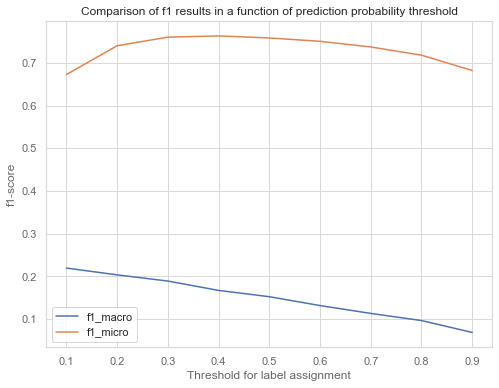

In [147]:
plt.figure(figsize=(8,6))
plt.plot(val_list, macro_f1_cnn, label = "f1_macro")
plt.plot(val_list, micro_f1_cnn, label = "f1_micro")
plt.title('Comparison of f1 results in a function of prediction probability threshold');
plt.xlabel('Threshold for label assignment')
plt.ylabel('f1-score')
plt.legend()
plt.show()

Conclusion: val = 0.3 seems to be the best for our needs

<br><br><br>
# Models Comparison

In [189]:
# Assign models:
models = []
models.append(('RF tfidf', grid_RF_tfidf.best_estimator_))
models.append(('RF Doc2Vec', grid_RF_D2V.best_estimator_))
models.append(('kNN tfidf', grid_kNN_tfidf.best_estimator_))
models.append(('kNN Doc2Vec', grid_kNN_D2V.best_estimator_))
models.append(('OvR_linSVC tfidf', grid_LinSVC_tfidf.best_estimator_))
models.append(('OvR_linSVC Doc2Vec', grid_LinSVC_D2V.best_estimator_))
models.append(('OvR_LogReg tfidf', grid_LR_tfidf.best_estimator_))
models.append(('OvR_LogReg Doc2Vec', grid_LR_D2V.best_estimator_))
models.append(('LP linSVC tfidf', grid_LP_LinSVC_tfidf.best_estimator_))
models.append(('CNN', model_CNN1))
models.append(('CNN_pretrained', model_CNN2))

# Initiate metrics:
accuracy = []
hamLoss = []
macro_precision = []
macro_recall = []
macro_f1 = []
micro_precision = []
micro_recall = []
micro_f1 = []
# auc = []

# Probability threshold to assign label in CNN models:
val = 0.5

# Iterate over models and calculate metrics
for name, model in models:
    if 'tfidf' in name.lower():
        y_pred = model.predict(X_test)
    elif 'doc2vec' in name.lower():
        y_pred = model.predict(X_test_D2V)
    elif 'cnn' in name.lower():
        y_pred = model.predict(X_test_pad)
        y_pred[y_pred>=val] = 1
        y_pred[y_pred<val] = 0
        y_pred = y_pred.astype(int)
    
    accuracy.append(accuracy_score(y_test, y_pred))
    hamLoss.append(hamming_loss(y_test, y_pred))
    
    macro_precision.append(precision_score(y_test, y_pred, average='macro'))
    macro_recall.append(recall_score(y_test, y_pred, average='macro'))
    macro_f1.append(f1_score(y_test, y_pred, average='macro'))

    micro_precision.append(precision_score(y_test, y_pred, average='micro'))
    micro_recall.append(recall_score(y_test, y_pred, average='micro'))
    micro_f1.append(f1_score(y_test, y_pred, average='micro'))


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad800

In [190]:
d = {'accuracy_score': accuracy, 
     'hamLoss': hamLoss, 
     'macro_precision': macro_precision,
     'micro_precision': micro_precision,
     'macro_recall' : macro_recall,
     'micro_recall' : micro_recall,
     'macro_f1' : macro_f1,
     'micro_f1' : micro_f1
#      'roc_auc_score' : roc_auc_score
    }

df = pd.DataFrame(data=d)
name, _ = zip(*models)
df.insert(loc=0, column='Method', value=name)
df = df.round(5)
df

,Method,accuracy_score,hamLoss,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1
0,RF tfidf,0.66380,0.00577,0.39603,0.96534,0.10951,0.60256,0.15399,0.74198
1,RF Doc2Vec,0.46373,0.00857,0.18998,0.96761,0.03176,0.39103,0.04563,0.55697
2,kNN tfidf,0.75124,0.00516,0.62708,0.85506,0.39613,0.75321,0.45370,0.80091
3,kNN Doc2Vec,0.59357,0.00917,0.41566,0.70687,0.19763,0.57131,0.23856,0.63191
4,OvR_linSVC tfidf,0.81385,0.00335,0.63838,0.94616,0.39377,0.80262,0.46472,0.86850
5,OvR_linSVC Doc2Vec,0.70984,0.00543,0.42709,0.82405,0.28018,0.77057,0.31590,0.79641
6,OvR_LogReg tfidf,0.80225,0.00355,0.60835,0.94155,0.36632,0.79167,0.43628,0.86013
7,OvR_LogReg Doc2Vec,0.71216,0.00534,0.42008,0.83518,0.26419,0.76335,0.30216,0.79766
8,LP linSVC tfidf,0.84366,0.00358,0.69697,0.90500,0.49197,0.82692,0.54133,0.86420
9,CNN,0.70553,0.00544,0.27413,0.91347,0.13729,0.66827,0.16344,0.77186


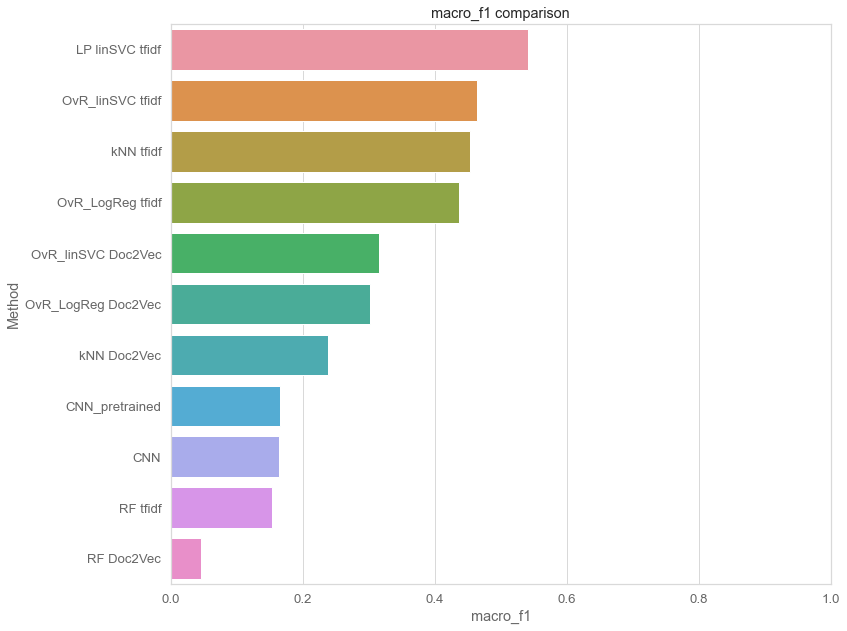

In [191]:
df_temp = df.sort_values(by="macro_f1",ascending=False)
sns.set(font_scale = 1.2)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x="macro_f1", y="Method", data=df_temp)
ax.axvline(x = -1, color = 'black', linewidth = 4, alpha = .7)
plt.xlim(0, 1)
plt.title('macro_f1 comparison')
plt.tight_layout()

plt.show()

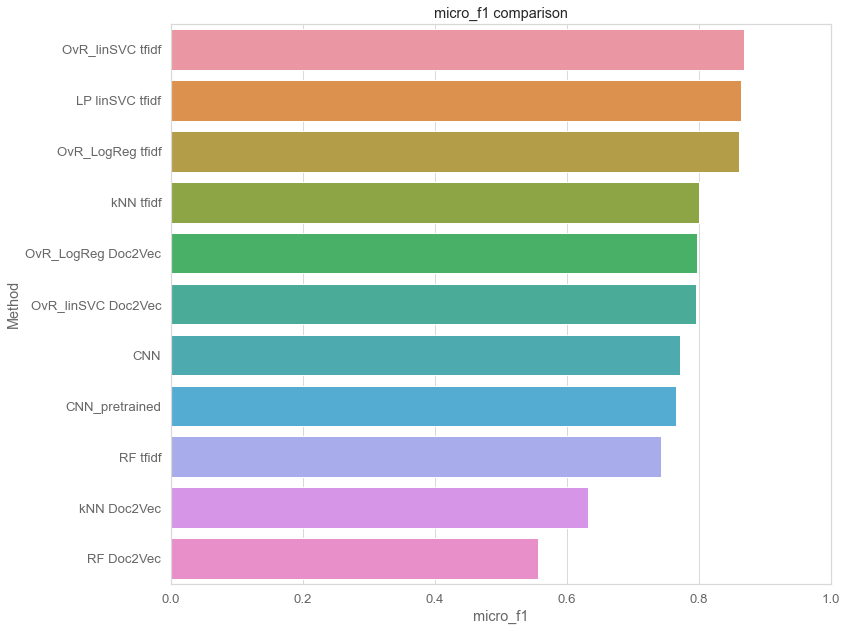

In [192]:
df_temp = df.sort_values(by="micro_f1",ascending=False)
sns.set(font_scale = 1.2)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x="micro_f1", y="Method", data=df_temp)
ax.axvline(x = -1, color = 'black', linewidth = 4, alpha = .7)
plt.xlim(0, 1)
plt.title('micro_f1 comparison')
plt.tight_layout()

plt.show()

### Take the best classifier and search over tfidf params:

In [194]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter = 10000)))
])

param_grid = {
    'vectorizer__min_df' : [1, 2, 3],
    'vectorizer__max_df' : [0.5, 0.6, 0.7, 0.8],
    'vectorizer__ngram_range' : [(1,1), (1,2), (1,3)],
    'clf__estimator__C': [0.1, 1, 10]
}

grid_LinSVC_tfidf2 = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LinSVC_tfidf2.fit(X_train, y_train)

print(f"Best params: {grid_LinSVC_tfidf2.best_params_}")
print(f"Train accuracy: {grid_LinSVC_tfidf2.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LinSVC_tfidf2.score(X_test, y_test)}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 57.9min finished


Best params: {'clf__estimator__C': 10, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}
Train accuracy: 0.9915046981593513
Test accuracy: 0.817157999337529


In [196]:
y_pred = grid_LinSVC_tfidf2.best_estimator_.predict(X_test)
metricsReport('OvR_LinSVC_tfidf_comparison', y_test, y_pred)

------OvR_LinSVC_tfidf_comparison Model Metrics-----
Accuracy: 0.8172
Hamming Loss: 0.0033
Precision:
  - Macro: 0.6724
  - Micro: 0.9396
Recall:
  - Macro: 0.4353
  - Micro: 0.8149
F1-measure:
  - Macro: 0.5048
  - Micro: 0.8728


Tuning TfIdf vectorizing has slightly increased the quality of the results!

<br><br><br>
# Conclusions & possible steps to enhance models

### Conclusions:
1. Classes with high number of labels are predicted much better than low occurence classes (models tend to predict 0's for low occurence classes) -> reparing this aspect should have highest impact on model marco metrics
2. Simple LinearSVC with TfIdf gives best results
3. Doc2Vec seems to have to small corpus to train
4. CNN would require more tests to be performed (pretrained vectors does not provide benefits compered to learning weights during model train)
    
### Next steps to enhance models:
1. Work on class imbalance:
    * oversampling / augmentation
    * class weights
    * for CNN: different probability thresholds depending on class occurences
    * group infrequent classes to one label
2. Work more on text preparation:
    * delete very short articles (there are articles with few words)
3. Try another models e.g. SGDclassifier with huber loss, RNN,...
4. Try other confifurations for CNN models (more filters, more convolutions, dense leyers)
